# Benchmarking on resampled protein embeddings

Evaluating 6 estimators on 200 datasets.

In [1]:
%%capture
from lmi import lmi
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm

import time
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

In [2]:
ecoli = pd.read_csv('../data/ProtT5_embeddings/Ecoli_preprocessed.csv', index_col=0)
print("%d sequences in E. Coli proteome" % len(ecoli))

athali = pd.read_csv('../data/ProtT5_embeddings/Athaliana_preprocessed.csv', index_col=0)
print("%d sequences in A. thaliana proteome" % len(athali))

4403 sequences in E. Coli proteome
27448 sequences in A. thaliana proteome


In [3]:
# first we construct a dataset where ecoli proteins and athali proteins are paired

X_data, Y_data = [np.zeros(1024)], [np.zeros(1024)]
labels = []

specs = [ecoli.to_numpy(), athali.iloc[:-1].to_numpy()] # drop last E Coli for even parity lol

s_names = ['E. Coli', 'A. Thaliana']

N_pairs = min([len(x) for x in specs])//2

for i in range(2):
    X_data = np.vstack((X_data, specs[i][:N_pairs]))
    Y_data = np.vstack((Y_data, specs[i][N_pairs:2*N_pairs]))
    labels += [s_names[i]]*(N_pairs)

X_data = np.array([x.flatten() for x in X_data[1:]])
Y_data = np.array([x.flatten() for x in Y_data[1:]])
labels = np.array(labels)

assert len(X_data) == len(labels)

def generate_dataset(percent_shuffle, N_samples=10**4):
    """
    shuffle pairs in a subset of the data
    """
    
    inds = np.arange(len(X_data))
    np.random.shuffle(inds)
    
    Xs = X_data[inds[:N_samples]].copy()
    Ys = Y_data[inds[:N_samples]].copy()
    Lx = labels[inds[:N_samples]].copy()
    Ly = labels[inds[:N_samples]].copy()
    
    rows_to_shuffle = int(percent_shuffle*len(Xs))
    
    # get identical shuffles
    # thanks to https://stackoverflow.com/questions/4601373/
    # better-way-to-shuffle-two-numpy-arrays-in-unison
    rng_state = np.random.get_state()
    np.random.shuffle(Xs[:rows_to_shuffle])
    np.random.set_state(rng_state)
    np.random.shuffle(Lx[:rows_to_shuffle])
    
    return Xs, Ys, Lx, Ly

Xs, Ys, Lx, Ly = generate_dataset(0.5)
print("Sanity check (percent identical labels, should be ~0.75): %f"
      %(sum(Lx == Ly)/len(Lx)))

Sanity check (percent identical labels, should be ~0.75): 0.753294


In [4]:
np.seterr(divide='ignore', invalid='ignore')

smi_d = {
    "Estimate" : [],
    "Label MI" : [],
    "Dimension" : [],
    "Measure" : [],
    "Time" : [],
    }

for ps in tqdm(np.linspace(0, 1, 200)):
    
    N_dims = 1024
    
    Xs, Ys, Lx, Ly = generate_dataset(ps**2)
    
    DMI = lmi.ksg.midd(Lx, Ly)
    Xs = np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))
    Ys = np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))

    t0 = time.time()
    mine = MINE(verbose=False)
    mine_mi = mine.estimate(Xs, Ys) # in nats
    t1 = time.time()
    
    smi_d["Estimate"].append(max(mine_mi/np.log(2), 0))
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("MINE")
    smi_d["Time"].append(t1-t0)

    t0 = time.time()
    infonce = InfoNCE(verbose=False)
    infonce_mi = infonce.estimate(Xs, Ys)
    t1 = time.time()
    
    smi_d["Estimate"].append(max(infonce_mi/np.log(2), 0))
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("InfoNCE")
    smi_d["Time"].append(t1-t0)

    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.ksg.mi(Xs, Ys)))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("KSG")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys, 
                                              regularizer='models.AECross')[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys, 
                                              regularizer='models.AEInfoNCE')[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI-InfoNCE")
    smi_d["Time"].append(t1-t0)
    
    t0 = time.time()
    smi_d["Estimate"].append(np.nanmean(lmi.lmi(Xs, Ys, 
                                               regularizer='models.AEMINE')[0]))
    t1 = time.time()
    smi_d["Label MI"].append(DMI)
    smi_d["Dimension"].append(N_dims)
    smi_d["Measure"].append("LMI-MINE")
    smi_d["Time"].append(t1-t0)

  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
smi_df = pd.DataFrame(smi_d)

<Axes: xlabel='Label MI', ylabel='Estimate'>

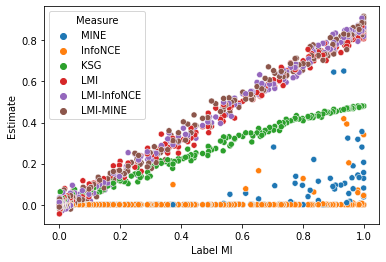

In [6]:
rcParams['figure.figsize'] = (4,4)
sns.scatterplot(smi_df,
                y='Estimate',
                x='Label MI',
                hue='Measure')

In [7]:
smi_df.to_csv("../results/B_species_mixing.csv")